# Data reduction workflow for LOKI detector test

The main purpose of this notebook is to compare data reduction workflows in scipp and Mantid. The workflow utilizes the direct_beam function generated using the Mantid script. It is also possible to run data reduction without direct_beam function.

The workflow involves several steps:
* Load added Mantid data files with load
* Apply LoadInstrument
* Use get real and simulated data to bypass loading from files
* Convert Mantid workspaces to scipp 
* Load masks from Mantid
* Load Monitors from Mantid
* Run sans.to_I_of_Q



In [1]:
import matplotlib.pyplot as plt
import scipp as sc
from ess import loki, sans
import scippneutron as scn
import plopp as pp

from mantid.simpleapi import *
from mantid.api import AnalysisDataService as ADS

%matplotlib widget

FrameworkManager-[Notice] Welcome to Mantid 6.7.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.7
CheckMantidVersion-[Notice] A new version of Mantid(6.8.0) is available for download from https://download.mantidproject.org
DownloadInstrument-[Notice] All instrument definitions up to date


## Define reduction workflow parameters

We define here whether to include the effects of gravity,
as well as common time-of-flight, wavelength and $Q$ bins for all the measurements.

We also define a range of wavelengths for the monitors that are considered to not be part of the background.

In [2]:
# Include effects of gravity?
gravity = True

#TODO: Using same wavelengths bins as direct beam is defined for but it may be different range (0.9-13.5)
wavelength_bins = sc.linspace(dim='wavelength', start=2.2, stop=12.0, num=50,
                              unit='angstrom')

q_bins = sc.linspace(dim='Q', start=0.004, stop=0.4, num=111, unit='1/angstrom')


## Loading data files


In [5]:
path = '/Users/wojciechpotrzebowski/SCIPP_SPACE/loki_detector_test/2022-06-24_calibrated_nexus_files/'
###########
sample_filename = '60395-mantid-add.nxs'
sample_trans_runnumber = '60394'
empty_beam_runnumber = '60392'
#########
background_filename='60393-mantid-add.nxs'
background_trans_runnumber = '60392'
empty_beam_runnumber = '60392'

#TODO: Need to update it
direct_beam = scn.load(f'{path}/flat_g4_final_15Jun23_10-17.nxs')

#idf_file = 'LARMOR_rear_bank_definition_noMonitors.xml'
idf_file = 'LOKI_test.xml'
nexus_file=Load(path + sample_filename)
LoadInstrument(Workspace='nexus_file', Filename=path+idf_file,
               MonitorList='', InstrumentName='LOKI', RewriteSpectraMap='True')
sample = scn.from_mantid(nexus_file)
sample = sample['data']

nexus_file=Load(path + background_filename)
LoadInstrument(Workspace='nexus_file', Filename=path+idf_file,
               MonitorList='', InstrumentName='LOKI', RewriteSpectraMap='True')
background = scn.from_mantid(nexus_file)
background = background['data']

ds = {'sample': sample, 
      'background': background}


scippneutron.load has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.load_with_mantid instead.


Load-[Notice] Load started
Load-[Notice] Load successful, Duration 13.35 seconds


scippneutron.array_from_mantid has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.from_mantid instead.
convert_Workspace2D_to_data_array is deprecated in favor of convert_Workspace2D_to_data_group.


DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
Load-[Notice] Load started
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
Load-[Notice] Load successful, Duration 1.03 seconds
LoadInstrument-[Notice] LoadInstrument started
LoadInstrument-[Warning] The instrument definition filename does not contain _Definition. Your instrument name will be set to: LOKI_test.xml
LoadInstrument-[Notice] LoadInstrument successful, Duration 0.04 seconds
Load-[Notice] Load started
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
Load-[Notice] Load successful, Duration 0.65 seconds
LoadInstrument-[Notice] LoadInstrument started
LoadInstrument-[Warning] The instr

## Apply corrections to pixel positions

We apply some corrections to the detector pixel and monitor positions,
as the geometry stored in the file is inaccurate.

In [6]:
for da in ds.values():    
    #Mimiciking no solid angle correction
    L2 = scn.L2(da)
    da.coords["pixel_width"] = L2
    da.coords["pixel_height"] = L2
    # #Coordinates from BCF
    x_offset = -0.0035 * sc.units.m
    y_offset = -0.0035 * sc.units.m
    
    da.coords['position'].fields.x += x_offset
    da.coords['position'].fields.y += y_offset


## Masking

We mask the edges of the detector, which are usually noisy.
We also mask the region close to the center of the beam,
so as to not include saturated pixels in our data reduction.

In [7]:
#Loading Mantid masks
idf_filename = f'{path}/LOKI_test.xml'
mask_file = f'{path}/mask_new_July2022.xml'
mask_all = scn.load(filename=idf_filename, mantid_alg="LoadMask", mantid_args={"InputFile": mask_file})
mask_file = f'{path}/mask_straws.xml' 
mask_straw = scn.load(filename=idf_filename, mantid_alg="LoadMask", mantid_args={"InputFile": mask_file})


for da in ds.values():
    da.masks['all'] = mask_all.data
    da.masks['straws'] = mask_straw.data

scippneutron.load has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.load_with_mantid instead.


LoadMask-[Notice] LoadMask started
LoadInstrument-[Warning] The instrument definition filename does not contain _Definition. Your instrument name will be set to: LOKI_test.xml


scippneutron.array_from_mantid has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.from_mantid instead.
convert_Workspace2D_to_data_array is deprecated in favor of convert_Workspace2D_to_data_group.


LoadMask-[Notice] LoadMask successful, Duration 0.38 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
LoadMask-[Notice] LoadMask started
LoadInstrument-[Warning] The instrument definition filename does not contain _Definition. Your instrument name will be set to: LOKI_test.xml


scippneutron.load has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.load_with_mantid instead.
scippneutron.array_from_mantid has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.from_mantid instead.
convert_Workspace2D_to_data_array is deprecated in favor of convert_Workspace2D_to_data_group.


LoadMask-[Notice] LoadMask successful, Duration 0.43 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


In [8]:
scn.instrument_view(ds['sample'].hist(), pixel_size=0.0075)

Box(children=(Figure(children=(HBar(children=(HTML(value=''),)), HBox(children=(VBar(children=(Toolbar(childre…

We can inspect that the coordinate corrections and masking were applied correctly by opening the instrument view.

### Mask Bragg peaks in wavelength

We will now take out the time regions with Bragg peaks from the beam stop and detector window, although in reality the peaks appear only close to the beam stop, and will make little difference to

This could be implemented as masking specific time bins for a specific region in space, but for now we keep it simple.

Note: For the purpose of this exercise we don't apply any mask here

In [9]:
wavelength_mask = None

### Loading Mantid monitors (pre-processed with Mantid)

In [10]:
sample_trans_monitor = scn.load(f'{path}/monitor_sample_trans.nxs')
sample_monitor = scn.load(f'{path}/monitor_sample.nxs')
background_trans_monitor= scn.load(f'{path}/monitor_can_trans.nxs')
background_monitor = scn.load(f'{path}/monitor_can.nxs')
monitor_flat = scn.load(f'{path}/monitor_flat.nxs')

scippneutron.load has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.load_with_mantid instead.


Load-[Notice] Load started


scippneutron.array_from_mantid has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.from_mantid instead.
convert_Workspace2D_to_data_array is deprecated in favor of convert_Workspace2D_to_data_group.
scippneutron.load has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.load_with_mantid instead.
scippneutron.array_from_mantid has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.from_mantid instead.
convert_Workspace2D_to_data_array is deprecated in favor of convert_Workspace2D_to_data_group.
scippneutron.load has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.load_with_mantid instead.


Load-[Notice] Load successful, Duration 0.21 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.07 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
Load-[Notice] Load started


scippneutron.array_from_mantid has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.from_mantid instead.
convert_Workspace2D_to_data_array is deprecated in favor of convert_Workspace2D_to_data_group.
scippneutron.load has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.load_with_mantid instead.
scippneutron.array_from_mantid has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.from_mantid instead.
convert_Workspace2D_to_data_array is deprecated in favor of convert_Workspace2D_to_data_group.
scippneutron.load has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.load_with_mantid instead.


Load-[Notice] Load successful, Duration 0.11 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.08 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 1.72 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


scippneutron.array_from_mantid has been deprecated and is scheduled for removal in scippneutron v24.01.0. Use the new scippneutron.from_mantid instead.
convert_Workspace2D_to_data_array is deprecated in favor of convert_Workspace2D_to_data_group.


In [11]:
sample_trans_monitor  = sample_trans_monitor.rebin(wavelength=wavelength_bins)
sample_monitor  = sample_monitor.rebin(wavelength=wavelength_bins)
background_trans_monitor  = background_trans_monitor.rebin(wavelength=wavelength_bins)
background_monitor  = background_monitor.rebin(wavelength=wavelength_bins)
monitor_flat  = monitor_flat.rebin(wavelength=wavelength_bins)

In [12]:
sample_monitor.coords['position'] = sc.vector(value=[0.0, 0.0, 9.8195], unit='m')
sample_monitor.coords['Ltotal'] =  9.8195 * sc.units.m

sample_trans_monitor.coords['position'] = sc.vector(value=[0.0, 0.0, 25.76], unit='m')
sample_trans_monitor.coords['Ltotal'] = 25.76 * sc.units.m

sample_trans_monitor.coords['position'] = sc.vector(value=[0.0, 0.0, 9.8195], unit='m')
background_monitor.coords['Ltotal'] = 9.8195 * sc.units.m

background_trans_monitor.coords['position'] = sc.vector(value=[0.0, 0.0, 25.76], unit='m')
background_trans_monitor.coords['Ltotal'] = 25.76 * sc.units.m

monitor_flat.coords['position'] = sc.vector(value=[0.0, 0.0, 25.76], unit='m')
monitor_flat.coords['Ltotal'] = 25.76 * sc.units.m

for mantid_monitor in [sample_monitor, sample_trans_monitor, background_monitor, background_trans_monitor, monitor_flat]:
    mantid_monitor.variances = None

In [13]:
sample_monitor.coords.set_aligned('position', False)
sample_monitor.coords.set_aligned('Ltotal', False)
sample_trans_monitor.coords.set_aligned('position', False)
sample_trans_monitor.coords.set_aligned('Ltotal', False)
sample_trans_monitor.coords.set_aligned('position', False)
sample_trans_monitor.coords.set_aligned('Ltotal', False)
background_trans_monitor.coords.set_aligned('position', False)
background_trans_monitor.coords.set_aligned('Ltotal', False)
monitor_flat.coords.set_aligned('position', False)
monitor_flat.coords.set_aligned('Ltotal', False)

In [14]:
sample_monitors = {'incident': sample_monitor, 'transmission': sample_trans_monitor}
empty_beam_monitors = {'incident': sample_monitor, 'transmission': monitor_flat}
background_monitors = {'incident': background_monitor, 'transmission':background_trans_monitor}

### Direct beam midpoints
This operation is needed for performing interpolation. Later, this can probably be dome i_of_q module, however we still need to see what exactly the format of direct beam function would be. 

In [15]:
direct_beam = direct_beam.rebin(wavelength=wavelength_bins)
direct_beam.coords['wavelength'] = sc.midpoints(direct_beam.coords['wavelength'])

In [16]:
#Setting direct beam to None for testing purposes
#direct_beam = None

In [17]:
#NOTE: direct monitors is the same as sample (and backgroud)
sample_q = sans.to_I_of_Q(data=ds['sample'],
    data_monitors=sample_monitors,
    direct_monitors=empty_beam_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_mask=wavelength_mask)

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


In [18]:
background_q = sans.to_I_of_Q(data=ds['background'],
    data_monitors=background_monitors,
    direct_monitors=empty_beam_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_mask=wavelength_mask)

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


We are now in a position to subtract the background from the sample measurement:

In [19]:
result = sample_q.bins.sum() - background_q.bins.sum()

In [20]:
result.plot()

invalid value encountered in add


InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

<div class="alert alert-info">

**Note**

Instead of `.bins.sum()`,
one could use `sc.histogram()` above to define different `Q` bins compared to the ones defined at the top of the notebook.
This can be done in event mode, see [here](https://scipp.github.io/user-guide/binned-data/computation.html#Subtraction).

There may be performance advantages to first use a coarse `Q` binning when the computing `I(Q)` numerator,
and use finer binning for the final results.

</div>

## Wavelength bands

It is often useful to process the data in a small number (~10) of separate wavelength bands.

This can be achieved by requesting 10 bands from the `to_I_of_Q` workflow via the `wavelength_bands` argument.

In [21]:
wavelength_bands = sc.linspace(dim='wavelength', start=2.2, stop=12.0, num=8,
                               unit='angstrom')

sample_slices = sans.to_I_of_Q(data=ds['sample'],
    data_monitors=sample_monitors,
    direct_monitors=empty_beam_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_bands=wavelength_bands,
    wavelength_mask=wavelength_mask)

background_slices = sans.to_I_of_Q(data=ds['background'],
    data_monitors=background_monitors,
    direct_monitors=empty_beam_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_bands=wavelength_bands,
    wavelength_mask=wavelength_mask)

result_slices = sample_slices.bins.sum() - background_slices.bins.sum()
result_slices

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.
An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


<scipp.DataArray>
Dimensions: Sizes[Q:110, wavelength:7, ]
Coordinates:
  L1                        float64              [m]  ()  25.61
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.004, 0.0076, ..., 0.3964, 0.4]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  incident_beam             vector3              [m]  ()  (0, 0, 25.61)
  sample_position           vector3              [m]  ()  (0, 0, 25.61)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2.2, 3.6, ..., 10.6, 12]
Data:
                            float32         [counts]  (Q, wavelength)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

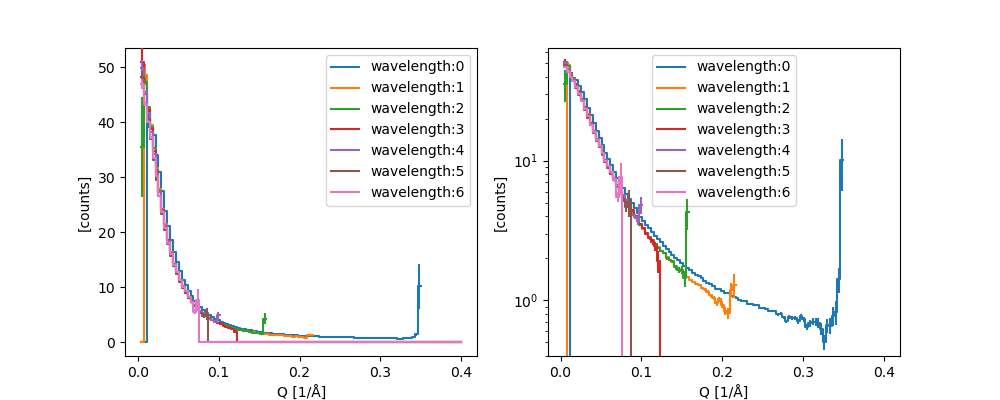

In [22]:
collapsed = sc.collapse(result_slices, keep='Q')

fig2, ax2 = plt.subplots(1, 2, figsize=(10, 4))
sc.plot(collapsed, ax=ax2[0])
sc.plot(collapsed, norm='log', ax=ax2[1])


### Benchmarking with Mantid (for a single slice)
- Comparision of denominator
- Comparison of nominator
- Comparison of slice/check if division works the same in scipp and mantid

In [23]:
# mantid_denominator_band_1 = scn.load(f'{path}/denominator_2-3.18_sa.nxs')
# mantid_denominator_band_1.data.unit = 'dimensionless'

In [24]:
# sc.plot({'scipp denominator': denominator_q_bands['wavelength', 0], 
#          'mantid denominator' :  1.3e11*mantid_denominator_band_1})

In [25]:
# mantid_nominator_band_1= scn.load(f'{path}/ISIS_polymer_slice_0_nominator.nxs')
                                     

In [26]:
# sc.plot({'scipp nominator 0': nominator_q_bands['wavelength', 0].bins.sum(), 
#          'mantid nominator 0':  1.45*mantid_nominator_band_1})

In [27]:
# mantid_slice_0 = scn.load(f'{path}/ISIS_polymer_slice_0.nxs')

In [28]:
# scipp_slice_0 = nominator_q_bands['wavelength', 0].bins.sum()/denominator_q_bands['wavelength', 0]

In [29]:
# result_slices['wavelength', 0].plot()
# sc.plot({'scipp calculated slice 0': scipp_slice_0,
#          'mantid slice 0':  1e-11*mantid_slice_0})
         #'mantid calculated slice 0': 9e-12*mantid_nominator_band_1/mantid_denominator_band_1})
# sc.plot({'scipp slice 0': result_slices['wavelength', 0],
#          'scipp calculated slice 0': scipp_slice_0,
#          'mantid slice 0':  9e-12*mantid_slice_0})
#          #'mantid calculated slice 0': 9e-12*mantid_nominator_band_1/mantid_denominator_band_1})

Note: Scipp division applied mantid nomimator/denominator gives the same result as from Mantid suggesting that the difference is related to the computation of nominator and denominator. It seems to me that differences come from the shift in coordinates position in scipp and mantid. It doesn't seem like there is a linear shift though.

In [30]:
# mantid_sample = scn.load(f'{path}/mantid_sample.nxs')

In [31]:
# mantid_sample 

## Running direct Mantid

In [32]:
# import mantid algorithms
from mantid.simpleapi import *

from mantid.api import AnalysisDataService as ADS
from mantid.api import WorkspaceGroup
from mantid.api import IEventWorkspace
from mantid.plots.utility import MantidAxType

In [ ]:
def getsimuldata(name, filename1, filename2, filepath, filepath_data, idf_file, wlist, step, xcen, ycen, monitor):
    # can pass the wavelength bins, beam centre, monitor detector_id etc  later
    nexus_file = Load(filepath_data + filename1)
    # have to pull in the idf now, else it overrides the Move !
    LoadInstrument(Workspace='nexus_file', Filename=filepath + idf_file, MonitorList='', InstrumentName='LOKI',
                   RewriteSpectraMap='True')
    print(nexus_file.getInstrument().getComponentByName('DetectorBench').getPos())
    MoveInstrumentComponent(Workspace='nexus_file', ComponentName="DetectorBench", X=xcen, Y=ycen, Z=0)

    # need to do the Move first, as might in detail change the time to wavelength conversion !
    # 11/6/21 sorted the 10 pixel shift in data, the centre is now correct.
    # MoveInstrumentComponent(Workspace='nexus_file',ComponentName="DetectorBench",X=0.02465,Y=0,Z=0)
    # print(mtd[name].getInstrument().getComponentByName('DetectorBench').getPos())
    #
    # created this mask by picking a rectangle in Mantid whilst in cylindricalY view
    # (if you use the default 3d view, you will only pick the front or rear straws that are visible, not the ones in the interior)
    # The RefWorkspace here is likely redundant
    nexus_file_orig = CloneWorkspace('nexus_file')

    for mfile in masklist_edge:
        LoadMask(mfile + '.xml', InputFile=filepath + mfile + '.xml', RefWorkspace='nexus_file',
                 OutputWorkspace='mask_ends_simul')
        MaskDetectors('nexus_file', MaskedWorkspace='mask_ends_simul')

    ConvertUnits(InputWorkspace=nexus_file, OutputWorkspace=name, Target='Wavelength', ConvertFromPointData=False)
    Rebin(InputWorkspace=name, OutputWorkspace=name, Params=str(wlist[0]) + ',' + str(wstep) + ',' + str(wlist[-1]),
          PreserveEvents=False)
    # Monitor isnt stored like this in new files 10/11/2022
    # ExtractSpectra(InputWorkspace=name, OutputWorkspace=monitor, StartWorkspaceIndex=1, EndWorkspaceIndex=1)

    nexus_file_mon = Load(filepath_data + filename2)
    ExtractSpectra(InputWorkspace='nexus_file_mon', OutputWorkspace='nexus_file_mon_sim', XMin=0,
                   WorkspaceIndexList='0')
    ConvertToHistogram(InputWorkspace='nexus_file_mon_sim', OutputWorkspace='nexus_file_mon_sim_his')
    detpars = CreateEmptyTableWorkspace()
    detpars.addColumn("int", "spectra")
    detpars.addColumn("double", "l1")
    detpars.addColumn("double", "l2")
    detpars.addColumn("double", "twotheta")
    detpars.addColumn("double", "efixed")
    detpars.addColumn("int", "emode")
    # Add the parameters
    detpars.addRow([1, 25.76, 0, 180.0, 0.0, 0])
    #detpars.addRow([1,  25760, 0, 180.0, 0.0, 0])
    wsOutmon = ConvertUnitsUsingDetectorTable('nexus_file_mon_sim_his', Target="Wavelength", DetectorParameters=detpars)
    Rebin(InputWorkspace=wsOutmon, OutputWorkspace=monitor,
          Params=str(wlist[0]) + ',' + str(wstep) + ',' + str(wlist[-1]), PreserveEvents=True)


def getrealdata(name, filename1, trans_runnumber, filepath, filepath_data, idf_file, wlist, step, xcen, ycen, monitor, trans):

    # can pass the wavelength bins, beam centre, monitor detector_id etc  later
    nexus_file =Load(filepath_data +filename1)
    # have to pull in the idf now, else it overrides the Move !
    LoadInstrument(Workspace='nexus_file', Filename=filepath +idf_file, MonitorList='', InstrumentName='LOKI', RewriteSpectraMap='True')
    # print(mtd[name].getInstrument().getComponentByName('DetectorBench').getPos())
    print(nexus_file.getInstrument().getComponentByName('DetectorBench').getPos())
    # need to do the Move first, as might in detail change the time to wavelength conversion !
    # pick APPROXIMATE centre from show instrument
    MoveInstrumentComponent(Workspace='nexus_file' ,ComponentName="DetectorBench" ,X=xcen ,Y=ycen ,Z=0)
    # print(mtd[name].getInstrument().getComponentByName('DetectorBench').getPos())

    # JH added - to mask prompt pulse - around 1500 and 17500 and 19000.
    # WP: switched off to compare 
    # MaskBins(InputWorkspace='nexus_file', OutputWorkspace='nexus_file' ,InputWorkspaceIndexType='WorkspaceIndex', XMin=5, XMax=4500)
    # MaskBins(InputWorkspace='nexus_file', OutputWorkspace='nexus_file' ,InputWorkspaceIndexType='WorkspaceIndex', XMin=17500, XMax=19000)

    # (if you use the default 3d view, you will only pick the front or rear straws that are visible, not the ones in the interior)
    # The RefWorkspace here is likely redundant
    nexus_file_orig =CloneWorkspace('nexus_file')

    for mfile in masklist_straws:
        LoadMask(mfile + '.xml' ,InputFile=filepath+ mfile + '.xml' ,RefWorkspace='nexus_file'
                 ,OutputWorkspace='mask_bs')
        MaskDetectors('nexus_file' ,MaskedWorkspace='mask_bs')

    for mfile in masklist_edge:
        LoadMask(mfile + '.xml' ,InputFile=filepath+ mfile + '.xml' ,RefWorkspace='nexus_file'
                 ,OutputWorkspace='mask_ends')
        MaskDetectors('nexus_file' ,MaskedWorkspace='mask_ends')

    ConvertUnits(InputWorkspace=nexus_file, OutputWorkspace=name, Target='Wavelength', ConvertFromPointData=False)

    Rebin(InputWorkspace=name, OutputWorkspace=name, Params=str(wlist[0] ) +', ' +str(wstep ) +', ' +str(wlist[-1]), PreserveEvents=True)

    # LOADING MONITORS IN TOF
    LoadNexus(Filename=filepath_data +trans_runnumber +'-monitor1-tof-add.nxs', OutputWorkspace=trans_runnumber +'_mon1')
    LoadNexus(Filename=filepath_data +trans_runnumber +'-monitor2-tof-add.nxs', OutputWorkspace=trans_runnumber +'_mon2')
    ws1 = CalculateFlatBackground(InputWorkspace=trans_runnumber +'_mon1', StartX=40000000, EndX=99000000, Mode='Mean')
    ws2 = CalculateFlatBackground(InputWorkspace=trans_runnumber +'_mon2', StartX=88000000, EndX=98000000, Mode='Mean')

    detpars = CreateEmptyTableWorkspace()
    detpars.addColumn("int", "spectra")
    detpars.addColumn("double", "l1")
    detpars.addColumn("double", "l2")
    detpars.addColumn("double", "twotheta")
    detpars.addColumn("double", "efixed")
    detpars.addColumn("int", "emode")

    # Add the parameters
    detpars.addRow([1,  9820, 0, 180.0, 0.0, 0])

    wsOut = ConvertUnitsUsingDetectorTable(ws1 ,Target="Wavelength" ,DetectorParameters=detpars)
    Rebin(InputWorkspace=wsOut, OutputWorkspace=trans_runnumber +'_mon1', Params=str(wlist[0] ) +', ' +str(wstep ) +', ' +str(wlist[-1]), PreserveEvents=True)
    DeleteWorkspace('wsOut')

    # Create a TableWorkspace to hold the detector parameters
    detpars = CreateEmptyTableWorkspace()
    detpars.addColumn("int", "spectra")
    detpars.addColumn("double", "l1")
    detpars.addColumn("double", "l2")
    detpars.addColumn("double", "twotheta")
    detpars.addColumn("double", "efixed")
    detpars.addColumn("int", "emode")

    # Add the parameters
    detpars.addRow([1,  25760, 0, 180.0, 0.0, 0])

    wsOut = ConvertUnitsUsingDetectorTable(ws2 ,Target="Wavelength" ,DetectorParameters=detpars)
    Rebin(InputWorkspace=wsOut, OutputWorkspace=trans_runnumber +'_mon2', Params=str(wlist[0] ) +', ' +str(wstep ) +', ' +str(wlist[-1]), PreserveEvents=True)
    DeleteWorkspace('wsOut')

    LoadNexus(Filename=filepath_data +MT_trans_runnumber +'-monitor1-tof-add.nxs', OutputWorkspace=MT_trans_runnumber +'_mon1')
    LoadNexus(Filename=filepath_data +MT_trans_runnumber +'-monitor2-tof-add.nxs', OutputWorkspace=MT_trans_runnumber +'_mon2')

    ws1 = CalculateFlatBackground(InputWorkspace=MT_trans_runnumber +'_mon1', StartX=40000000, EndX=99000000, Mode='Mean')
    ws2 = CalculateFlatBackground(InputWorkspace=MT_trans_runnumber +'_mon2', StartX=88000000, EndX=98000000, Mode='Mean')

    detpars = CreateEmptyTableWorkspace()
    detpars.addColumn("int", "spectra")
    detpars.addColumn("double", "l1")
    detpars.addColumn("double", "l2")
    detpars.addColumn("double", "twotheta")
    detpars.addColumn("double", "efixed")
    detpars.addColumn("int", "emode")

    # Add the parameters
    detpars.addRow([1,  9820, 0, 180.0, 0.0, 0])

    wsOut = ConvertUnitsUsingDetectorTable(ws1 ,Target="Wavelength" ,DetectorParameters=detpars)
    Rebin(InputWorkspace=wsOut, OutputWorkspace=MT_trans_runnumber +'_mon1', Params=str(wlist[0] ) +', ' +str(wstep ) +', ' +str(wlist[-1]), PreserveEvents=True)
    DeleteWorkspace('wsOut')

    # Create a TableWorkspace to hold the detector parameters
    detpars = CreateEmptyTableWorkspace()
    detpars.addColumn("int", "spectra")
    detpars.addColumn("double", "l1")
    detpars.addColumn("double", "l2")
    detpars.addColumn("double", "twotheta")
    detpars.addColumn("double", "efixed")
    detpars.addColumn("int", "emode")

    # Add the parameters
    detpars.addRow([1,  25760, 0, 180.0, 0.0, 0])

    wsOut = ConvertUnitsUsingDetectorTable(ws2 ,Target="Wavelength" ,DetectorParameters=detpars)
    Rebin(InputWorkspace=wsOut, OutputWorkspace=MT_trans_runnumber +'_mon2', Params=str(wlist[0] ) +', ' +str(wstep ) +', ' +str(wlist[-1]), PreserveEvents=True)
    DeleteWorkspace('wsOut')
    CloneWorkspace(InputWorkspace=trans_runnumber +'_mon2' ,OutputWorkspace=monitor)

    # check that i shouldnt normalise the mon2 to mon 1 first - I think the below corrects for that already

    Divide(LHSWorkspace=MT_trans_runnumber +'_mon1' ,RHSWorkspace=MT_trans_runnumber +'_mon2'
           ,OutputWorkspace='MT_mon_ratio')
    Divide(LHSWorkspace=trans_runnumber +'_mon1' ,RHSWorkspace=trans_runnumber +'_mon2' ,OutputWorkspace='mon_ratio')
    Divide(LHSWorkspace='MT_mon_ratio' ,RHSWorkspace='mon_ratio' ,OutputWorkspace=trans)
    # Rebin(InputWorkspace=trans, OutputWorkspace=trans, Params=str(wlist[0])+','+str(wstep)+','+str(wlist[-1]), PreserveEvents=True)

    CloneWorkspace(InputWorkspace=trans_runnumber +'_mon2' ,OutputWorkspace=monitor)

In [33]:
def crop_the_nans(wksp):
    # this only removes contiguous runs of NaN at start and end of a workspace
    # if there are embedded Nan givng torubles, e.g. with division, then make the Q bins larger or
    # consider using ReplaceSpecialValues
    # grr found one case where "inf" appeared rather than nan, try isfinite which does +-inf and nan
    X= mtd[str(wksp)].readX(0)
    Y= mtd[str(wksp)].readY(0)
    index1=0
    index2=len(Y)-1
    #print(wksp,len(Y),index1,index2)
    while index1 < len(Y)-1:
        if( not np.isfinite(Y[index1]) ):
            index1 +=1
        else:
            break
#
    while index2 > 0:
        if( not np.isfinite(Y[index2]) ):
            index2 -=1
        else:
            break
    # all nan's e.g. i1=0, i2=68, becomes i1=68, i2=0 
    #print(wksp,len(Y),index1,index2)
    # this does not work as StartWorkspaceIndex is expected to be a spectrum number!
    #CropWorkspace(InputWorkspace=wksp,OutputWorkspace=wksp+'_crop',StartWorkspaceIndex=index1, EndWorkspaceIndex=index2)
    # so now we need the X values also
    # note this is a pseudo histogram, Y vales are distribution if this is reduced I(Q), but X values are bin boundaries
    #
    if( index2 >= index1):
        CropWorkspace(InputWorkspace=wksp,OutputWorkspace=wksp,XMin=X[index1], XMax=X[index2+1] )
    else:
        # try rebin to a single large bin, Qmin, Qstep, Qmax, then set result to zero
        # this gives a workspace with one Y value, two X values, can do "show data" on it BUT it won't plot !
        rebinstring=str(X[0])+','+str(X[-1]-X[0])+','+str(X[-1])
        print(wksp,' is empty rebin and set zero, Q=',rebinstring)
        Rebin(InputWorkspace=wksp,OutputWorkspace=wksp,Params=rebinstring)
        # alas,  nan * 0.0 = nan, setY seems not to work for histogram ???
        #Scale(InputWorkspace=wksp,OutputWorkspace=wksp,Operation='Multiply',Factor=0.0)
        ReplaceSpecialValues(InputWorkspace=wksp,OutputWorkspace=wksp,NaNValue=0.0,NaNError=0.0,InfinityValue=0.0,InfinityError=0.0)


def reduce(rebinall0,name,wlist,wstep,qbins,monitor,solidanglecorr,wavadj0,wavpixeladj00,saveNumDen):
    print(rebinall0,name,wlist,wstep,qbins,monitor,solidanglecorr,wavadj0,wavpixeladj00,saveNumDen)
    out=[]
    if (saveNumDen > 0):
        parts=True
    else:
        parts=False
    # DONE: assume that all input data is already in correct and matching wavelength bins
    # OOPS 27/1/22  if data is in e.g. 2 to 13 Ang, but call here with wlist=[5.0,7.0] the rebin is not being done!, whilst wlist=[2.0,13.0] would be OK
    # I had cut this out to save yet another clone of the data
    # TODO: if calling this multiple times with same data & wlist, could rebin the SANS data into slices just the first time.
    #       i.e. write another version that uses pre-sliced SANS data
    # 27/1/22 put back the monitor rebin, should be quick
    # TODO: ought really also to check the wav range of monitor and wavadj0 
    Rebin(InputWorkspace=monitor, OutputWorkspace='waveadjall', Params=str(wlist[0])+','+str(wstep)+','+str(wlist[-1]) )
    if(wavadj0 != 'None'):
        waveadjall2 = CloneWorkspace(wavadj0)
        RebinToWorkspace(WorkspaceToRebin=waveadjall2,WorkspaceToMatch='waveadjall', OutputWorkspace='waveadjall2')
        waveadjall = Multiply(LHSWorkspace='waveadjall',RHSWorkspace='waveadjall2')
    wavadjname='waveadjall'
    #
    # 27/1/22 now check the wavelength range of the input data, clone & rebin if needed  
    x_values=mtd[rebinall0].readX(0)
    #print('wav range data =',x_values)
    rebinall = rebinall0
    if (x_values[0] != wlist[0] or x_values[-1] != wlist[-1]):
        if(wlist[0] < x_values[0] or wlist[-1] > x_values[-1]):
            # TODO: find out how to flag proper error
            print('*** ERROR *** - data wavelength mis-match wlist ',wlist[0],' to ',wlist[-1],'  data ',x_values[0],' to ',x_values[-1])
            name1 = name+'_Q1D_'+str(wlist[0])+'_'+str(wlist[-1])+'_ERROR_wav'
            wksptemp=CreateWorkspace(DataX=[0.0,1000.0], DataY=[0.0], UnitX="MomentumTransfer",Distribution=True)
            RenameWorkspace( InputWorkspace='wksptemp',OutputWorkspace=name1)
            out.append(name1)
            return out
            # note if you just carry on the "extrapolated" data from the rebin will have simply been set to zero!
        Rebin(InputWorkspace=rebinall0, OutputWorkspace='rebinall', Params=str(wlist[0])+','+str(wstep)+','+str(wlist[-1]), PreserveEvents=False)
        rebinall='rebinall'
    # Note also that Q1D runs parallel code if multiple cpu are present.
    nslice=len(wlist)-1
    #
    # 27/1/22 check wavelength range of wavpixeladj, clone & rebin if needed
    wavpixeladj0 = wavpixeladj00
    if (wavpixeladj00 != 'None'):
        x_values=mtd[wavpixeladj00].readX(0)
        #print('wav range wavpixeladj00 =',x_values)
        if (x_values[0] != wlist[0] or x_values[-1] != wlist[-1]):
            if(wlist[0] < x_values[0] or wlist[-1] > x_values[-1]):
                # TODO: find out how to flag proper error
                print('*** ERROR *** - wavpixleadj wavelength mis-match wlist ',wlist[0],' to ',wlist[-1],'  data ',x_values[0],' to ',x_values[-1])
                name1 = name+'_Q1D_'+str(wlist[0])+'_'+str(wlist[-1])+'_ERROR_wav'
                wksptemp=CreateWorkspace(DataX=[0.0,1000.0], DataY=[0.0], UnitX="MomentumTransfer",Distribution=True)
                RenameWorkspace( InputWorkspace='wksptemp',OutputWorkspace=name1)
                out.append(name1)
                return out
            Rebin(InputWorkspace=wavpixeladj00, OutputWorkspace='wavpixeladj0', Params=str(wlist[0])+','+str(wstep)+','+str(wlist[-1]) )
            wavpixeladj0 = 'wavpixeladj0'

    name1 = name+'_Q1D_0_'+str(wlist[0])+'_'+str(wlist[-1])
    out.append(name1)
    for i in range(0, nslice):
        Rebin(InputWorkspace=wavadjname, OutputWorkspace='waveadjslice', Params=str(wlist[i])+','+str(wstep)+','+str(wlist[i+1]) )
        # try redundant clone here
        #rebinall=CloneWorkspace(rebinall0)
        Rebin(InputWorkspace=rebinall, OutputWorkspace='rebinslice', Params=str(wlist[i])+','+str(wstep)+','+str(wlist[i+1]), PreserveEvents=False)
        name2 = name+'_Q1D_'+str(i+1)+'_'+str(wlist[i])+'_'+str(wlist[i+1])
        out.append(name2)
        #TODO:  tried passing None (without any quotes) but could not get it to work, so avoid the issue here  with this if else ......
        if (wavpixeladj0 != 'None'):
                print("################### Reduction with wavpixeladj00")
                Rebin(InputWorkspace=wavpixeladj0, OutputWorkspace='wavpixeladjslice', Params=str(wlist[i])+','+str(wstep)+','+str(wlist[i+1]) )
                Q1D(DetBankWorkspace='rebinslice', OutputWorkspace=name2, OutputBinning=qbins, WavelengthAdj='waveadjslice',WavePixelAdj='wavpixeladjslice', SolidAngleWeighting=solidanglecorr, OutputParts=True)
        else:
                print("################### Reduction without wavpixeladj00")
                Q1D(DetBankWorkspace='rebinslice', OutputWorkspace=name2, OutputBinning=qbins, WavelengthAdj='waveadjslice',WavePixelAdj=None, SolidAngleWeighting=solidanglecorr, OutputParts=True)

        # sum numerator & denominator for the full wavelength range
        if (i==0):
                CloneWorkspace(InputWorkspace=name2 +'_sumOfCounts', OutputWorkspace='summedSumCounts')
                CloneWorkspace(InputWorkspace=name2 +'_sumOfNormFactors', OutputWorkspace='summedSumNorm')
        else:
                Plus(LHSWorkspace='summedSumCounts',RHSWorkspace=name2 +'_sumOfCounts',OutputWorkspace='summedSumCounts')
                Plus(LHSWorkspace='summedSumNorm',RHSWorkspace=name2 + '_sumOfNormFactors',OutputWorkspace='summedSumNorm')
                   
        if(parts==False):
                DeleteWorkspace(name2 +'_sumOfCounts')
                DeleteWorkspace(name2 +'_sumOfNormFactors')

            #crop_the_nans(name2)
            
        
        Divide(LHSWorkspace='summedSumCounts',RHSWorkspace='summedSumNorm',OutputWorkspace=name1)

    return out

def reducesamcan(run,can,string,wlist,wstep,qbins,monitor_run,monitor_can,
                 solidanglecorr,wavadj0,wavpixeladjname,saveNumDen):
    
    out2 = reduce(run,string,wlist,wstep,qbins,monitor_run,solidanglecorr,wavadj0,wavpixeladjname,saveNumDen)
    out3 = reduce(can,string+'_can',wlist,wstep,qbins,monitor_can,solidanglecorr,wavadj0,wavpixeladjname,saveNumDen)
    
    nslice=len(wlist)-1
    tag='_'
    if(nslice > 1):
        tag='_0_'
    name1=string   # e.g. sample_wp
    name2='_Q1D'+tag+str(wlist[0])+'_'+str(wlist[-1])
    #TODO: ought to use the actual names returned in say out3 then replace _can by _sc, then would not have to presume the naming convention
    sam = name1 + name2
    can = name1+'_can'+name2
    sc = name1+'_sc'+name2
    # might even need to tediously check the actual Q range here, or rebin can to match sample ?
    substracted_wksp = Subtract(LHSWorkspace=sam,RHSWorkspace=can,OutputWorkspace=sc)
    out=[]
    scipp_wksps = []
    out.append(sc)
    scipp_wksps.append(scn.from_mantid(substracted_wksp))
    if (nslice > 1):
        for i in range(0, nslice):
            name2='_Q1D_'+str(i+1)+'_'+str(wlist[i])+'_'+str(wlist[i+1])
            sam = name1 + name2
            can = name1+'_can'+name2
            sc = name1+'_sc'+name2
            # might even need to tediously check the actual Q range here
            substracted_wksp = Subtract(LHSWorkspace=sam,RHSWorkspace=can,OutputWorkspace=sc)
            scipp_wksps.append(scn.from_mantid(substracted_wksp))
            out.append(sc)
    return out, scipp_wksps



In [34]:
masklist_edge=['mask_new_July2022']
masklist_straws=['mask_straws']

wavpixeladjname = 'flat_g4'

wlist = [2.2, 3.2, 3.8, 4.4, 5.0, 6.0, 7.0, 8.0, 9.0, 10.5, 12]
wlist = [2.2,12]
wlist = [2.2 ,  3.18,  4.16,  5.14,  6.12,  7.1 ,  8.08,  9.06, 10.04, 11.02, 12.0]
wlist = [2.2,  3.6,  5. ,  6.4,  7.8,  9.2, 10.6, 12.]

wstep = 0.2
saveNumDen = 1
qbins = '0.004,0.0036,0.4'
xcen = -0.0035
ycen = -0.0035

# x_offset = 0.028 * sc.units.m
# y_offset = 0.01195 * sc.units.m

user_path = "/Users/wojciechpotrzebowski/SCIPP_SPACE/direct_beam_iterations_2023/"
filepath = user_path
filepath_data = user_path

idf_file = 'LOKI_test.xml'
solidanglecorr = False

#########Loading direct beam
filename = "flat_g4_final_15Jun23_10-17.nxs"  # Latest draft with all layers corrected, need to work on that
filename2 = 'realSetupFloodSource_rearBankLarmor_000000to199999_mcstas_new.nxs'  # new flood source - might be the wrong sample to use here 09/11/22
getsimuldata('flat_g4', filename, filename2, filepath, filepath_data, idf_file, wlist, wstep, xcen, ycen,
                 'monitor_flat')


###########
filename = '60395-mantid-add.nxs'
trans_runnumber = '60394'
MT_trans_runnumber = '60392'

getrealdata('sample', filename, trans_runnumber, filepath, filepath_data, idf_file, wlist, wstep, xcen, ycen,
                'sample_monitor', 'sample_trans')


#########
filename='60393-mantid-add.nxs'
trans_runnumber = '60392'
MT_trans_runnumber = '60392'

#JH: Load can, e.g. background. (same can for all the samples we measured.)
getrealdata('can', filename, trans_runnumber, filepath, filepath_data, idf_file,wlist,wstep,xcen, ycen,'can_monitor', 'can_trans')

#TODO: Why this is dome for reduction?
sample_monratio=Divide('sample_monitor','monitor_flat')
sample_wavadj=Multiply('sample_monratio','sample_trans')

can_monratio=Divide('can_monitor','monitor_flat')
can_wavadj=Multiply('can_monratio','can_trans')


out, scipp_wksps =reducesamcan('sample','can','ISIS_polymer' 
                               ,wlist,wstep,qbins,'sample_wavadj','can_wavadj',
                               solidanglecorr,'None',wavpixeladjname,saveNumDen)

#No solid angle neither direct beam
# out, scipp_wksps =reducesamcan('sample','can','ISIS_polymer' 
#                                ,wlist,wstep,qbins,'sample_wavadj','can_wavadj',
#                                solidanglecorr,'None','None',saveNumDen)



Load-[Notice] Load started
Load-[Notice] Load successful, Duration 11.66 seconds
LoadInstrument-[Notice] LoadInstrument started
LoadInstrument-[Warning] The instrument definition filename does not contain _Definition. Your instrument name will be set to: LOKI_test.xml
LoadInstrument-[Notice] LoadInstrument successful, Duration 0.05 seconds
[-0.02,-0.207948,29.4479]
MoveInstrumentComponent-[Notice] MoveInstrumentComponent started
MoveInstrumentComponent-[Notice] MoveInstrumentComponent successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.25 seconds
LoadMask-[Notice] LoadMask started
LoadMask-[Notice] LoadMask successful, Duration 0.42 seconds
MaskDetectors-[Notice] MaskDetectors started
MaskDetectors-[Notice] Masking using workspace indicies
MaskDetectors-[Notice] MaskDetectors successful, Duration 0.55 seconds
ConvertUnits-[Notice] ConvertUnits started
ConvertUnits-[Notice] ConvertUnits successful

In [35]:
#sc.plot({'scipp_nominator': nominator_q_bands['wavelength', 0].hist(), 'mantid_nominator': scn.from_mantid(mtd['ISIS_polymer_Q1D_1_2.2_3.6_sumOfCounts'])['data']})

In [36]:
#sc.plot({'scipp_nominator': nominator_q_bands['wavelength', 1].hist(), 'mantid_nominator': scn.from_mantid(mtd['ISIS_polymer_Q1D_2_3.6_5.0_sumOfCounts'])['data']})

In [37]:
#sc.plot({'scipp_nominator': nominator_q_bands['wavelength', 2].hist(), 'mantid_nominator': scn.from_mantid(mtd['ISIS_polymer_Q1D_3_5.0_6.4_sumOfCounts'])['data']})

In [38]:
#sc.plot({'scipp_nominator': nominator_q_bands['wavelength', 3].hist(), 'mantid_nominator': scn.from_mantid(mtd['ISIS_polymer_Q1D_4_6.4_7.8_sumOfCounts'])['data']})

In [39]:
#sc.plot({'scipp_nominator': nominator_q_bands['wavelength', 4].hist(), 'mantid_nominator': scn.from_mantid(mtd['ISIS_polymer_Q1D_5_7.8_9.2_sumOfCounts'])['data']})

In [40]:
#sc.plot({'scipp_nominator': nominator_q_bands['wavelength', 5].hist(), 'mantid_nominator': scn.from_mantid(mtd['ISIS_polymer_Q1D_6_9.2_10.6_sumOfCounts'])['data']})

In [41]:
#sc.plot({'scipp_nominator': nominator_q_bands['wavelength', 6].hist(), 'mantid_nominator': scn.from_mantid(mtd['ISIS_polymer_Q1D_7_10.6_12.0_sumOfCounts'])['data']})

In [42]:
#scn.instrument_view(scn.from_mantid(mtd['sample'])['data'].hist(), pixel_size=0.0075)

In [43]:
#scn.instrument_view(ds['sample'].hist(), pixel_size=0.0075)

In [44]:
# a = ds['sample'].hist().sum('tof')
# sel = a.masks['all'] | a.masks['straws']
# a[~sel].data.max()

In [53]:
mantid_slice_1  = scn.from_mantid(mtd['ISIS_polymer_Q1D_1_2.2_3.6'])['data']
sc.plot({'scipp 2.2-3.6 Å': result_slices['wavelength', 0], 
         'mantid 2.2-3.6 Å' : mantid_slice_1})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [46]:
mantid_slice_2  = scn.from_mantid(mtd['ISIS_polymer_Q1D_2_3.6_5.0'])['data']
sc.plot({'scipp slice': result_slices['wavelength', 1], 
         'mantid slice' : mantid_slice_2})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [55]:
mantid_slice_3  = scn.from_mantid(mtd['ISIS_polymer_Q1D_3_5.0_6.4'])['data']
sc.plot({'scipp 5.0-6.4 Å': result_slices['wavelength', 2], 
         'mantid 5.0-6.4 Å' : mantid_slice_3})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [57]:
mantid_slice_4  = scn.from_mantid(mtd['ISIS_polymer_Q1D_4_6.4_7.8'])['data']
sc.plot({'scipp 6.4-7.8 Å': result_slices['wavelength', 3], 
         'mantid 6.4-7.8 Å' : mantid_slice_4})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [49]:
mantid_slice_5  = scn.from_mantid(mtd['ISIS_polymer_Q1D_5_7.8_9.2'])['data']
sc.plot({'scipp slice': result_slices['wavelength', 4], 
         'mantid slice' : mantid_slice_5})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [50]:
mantid_slice_6  = scn.from_mantid(mtd['ISIS_polymer_Q1D_6_9.2_10.6'])['data']
sc.plot({'scipp slice': result_slices['wavelength', 5], 
         'mantid slice' : mantid_slice_6})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [58]:
mantid_slice_7  = scn.from_mantid(mtd['ISIS_polymer_Q1D_7_10.6_12.0'])['data']
sc.plot({'scipp 10.6-12 Å': result_slices['wavelength', 6], 
         'mantid 10.6-12 Å' : mantid_slice_7})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [54]:
mantid_result = scn.from_mantid(mtd['ISIS_polymer_Q1D_0_2.2_12.0'])['data']
mantid_result.unit = 'counts'
sc.plot({'scipp 2.2-12Å': result, 'mantid 2.2-12Å': mantid_result})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

## Saving to file
Finally we save reduced data to file